# Stock Price Prediction: Microsoft
In this project we will use the Microsoft stock market index for NYSE. We will predict directionality of price whether it will go up or go down.

With help of this project we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up. We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

We want to maximize our true positives - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives i.e. the days when we buy the stock, but the price actually goes down.

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

## Method

Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:

   * Download historical stock prices from Yahoo finance
   * Explore the data
   * Setup the dataset to predict future prices using historical prices
   * Test a machine learning model
   * Setup a backtesting engine
   * Improve the accuracy of the model

At the end, we'll document some potential future directions we can go in to improve the technique.

## Downloading the data

We will use yfinance to download the data from the yahoo finanace website, We will use the Ticker method from yfinance to get data for a particular stock index.

We'll use data for a single stock (Microsoft) from when it started trading to the present.


In [1]:
#Importing all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import yfinance as yf         # import Yahoo! Finance
except:
    ! pip install yfinance
    import yfinance as yf         # import Yahoo! Finance

  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=e4fcbfee85a3664c8a2515edc1d3166807a609f98edfa2b5cf3235042cff1bb5
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking


In [2]:
#Initialising ticker class which will enable us to download price history
msft = yf.Ticker("MSFT")

In [3]:
#Query the historical prices of Miscrosoft and storing it.
msft = msft.history(period="max")



As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

   * Open - the price the stock opened at.
   * High - the highest price during the day
   * Low - the lowest price during the day
   * Close - the closing price on the trading day
   * Volume - how many shares were traded

Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.


In [4]:
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064384,133171200,0.0,0.0
1986-03-18,0.064384,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,46135800,0.0,0.0
2022-06-14,243.860001,245.740005,241.509995,244.490005,28651500,0.0,0.0
2022-06-15,248.309998,255.300003,246.419998,251.759995,33111700,0.0,0.0


In [5]:
#the index is already in datetime which is good for us as we don't have to correct the dataype for the dates
msft.index

DatetimeIndex(['1986-03-13', '1986-03-14', '1986-03-17', '1986-03-18',
               '1986-03-19', '1986-03-20', '1986-03-21', '1986-03-24',
               '1986-03-25', '1986-03-26',
               ...
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-13', '2022-06-14', '2022-06-15',
               '2022-06-16', '2022-06-17'],
              dtype='datetime64[ns]', name='Date', length=9142, freq=None)

Next, we'll plot the data so we can see how the stock price has changed over time. This gives us another overview of the structure of the data.

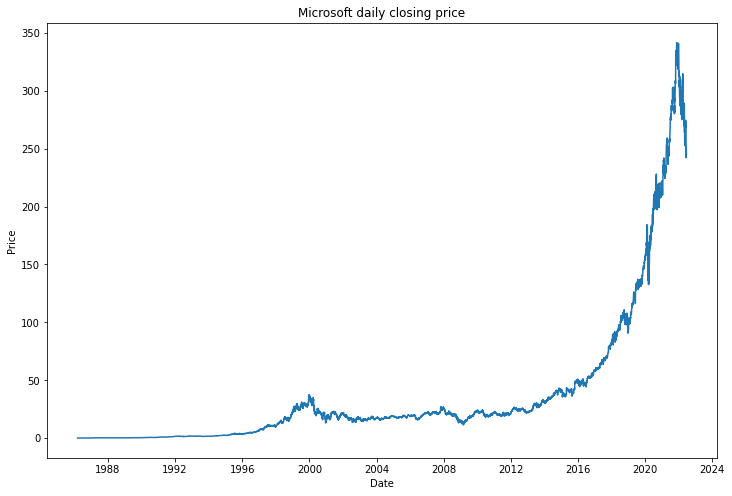

In [6]:
#plotting a chart for closing price
plt.figure(figsize=(12,8))
plt.plot(msft["Close"])
plt.title("Microsoft daily closing price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


## Preparing the data
Now, let's prepare the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1 and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions.

Then, we'll combine both so we have our training data.


In [7]:
#The Dividends and Stock splits are not useful for index, so dropping the columns
del msft['Dividends']
del msft['Stock Splits']

Creating a new column tomorrow to store the next days closing price which we will use to predict the direction of the price

In [8]:

msft['Tomorrow'] = msft['Close'].shift(-1)

In [9]:
msft

,Open,High,Low,Close,Volume,Tomorrow
Date,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.063292
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.064384
1986-03-17,0.063292,0.064929,0.063292,0.064384,133171200,0.062746
1986-03-18,0.064384,0.064929,0.062201,0.062746,67766400,0.061655
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.060018
...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,46135800,244.490005
2022-06-14,243.860001,245.740005,241.509995,244.490005,28651500,251.759995
2022-06-15,248.309998,255.300003,246.419998,251.759995,33111700,244.970001


We will create a target based on the Tomorrow column, whether the price will be high or low on the next day.
Converting the columns to int type to use it in our models

In [10]:
msft['Target'] = (msft['Tomorrow']> msft['Close']).astype(int)

In [11]:
msft

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.063292,1
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.064384,1
1986-03-17,0.063292,0.064929,0.063292,0.064384,133171200,0.062746,0
1986-03-18,0.064384,0.064929,0.062201,0.062746,67766400,0.061655,0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.060018,0
...,...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,46135800,244.490005,1
2022-06-14,243.860001,245.740005,241.509995,244.490005,28651500,251.759995,1
2022-06-15,248.309998,255.300003,246.419998,251.759995,33111700,244.970001,0


Taking the data from 1990 as taking much historic data could affect the models performance for current dates 

In [12]:
msft_90s = msft.loc["1990-01-01":]

In [13]:
msft_90s

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,0.380843,0.387390,0.375932,0.387390,53035200,0.389573,1
1990-01-03,0.390664,0.393938,0.386299,0.389573,113774400,0.401031,1
1990-01-04,0.389573,0.401577,0.387390,0.401031,125740800,0.391210,0
1990-01-05,0.399394,0.401577,0.390664,0.391210,69566400,0.397212,1
1990-01-08,0.390665,0.397212,0.386299,0.397212,58982400,0.396120,0
...,...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,46135800,244.490005,1
2022-06-14,243.860001,245.740005,241.509995,244.490005,28651500,251.759995,1
2022-06-15,248.309998,255.300003,246.419998,251.759995,33111700,244.970001,0


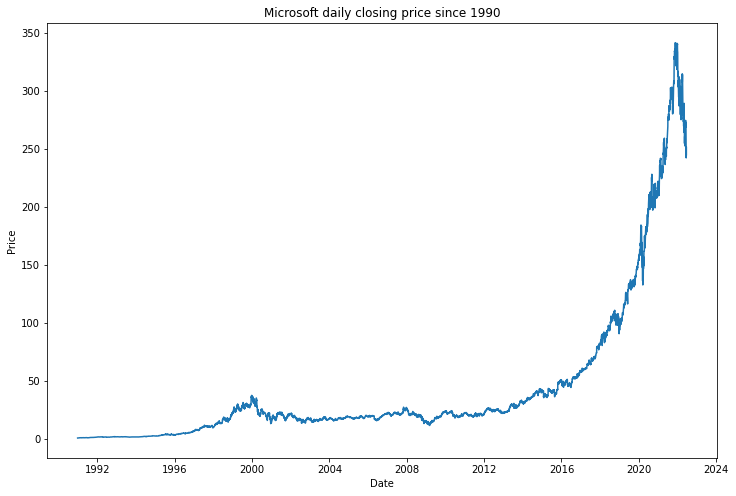

In [39]:
plt.figure(figsize=(12,8))
plt.plot(msft_90s["Close"])
plt.title("Microsoft daily closing price since 1990")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


## Creating a machine learning model

Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.


In [15]:
# importing the model and providing parameters, later we can play with the parameters to get better predictions
from sklearn.ensemble import RandomForestClassifier

model  = RandomForestClassifier(n_estimators = 100, min_samples_split=100, random_state=1)

In [16]:
#splitting data
train = msft_90s.iloc[:-100]
test = msft_90s.iloc[-100:]

predictors = ["Close","Volume","Open","High","Low"]
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

Using precision score metric to verfiy the confidence of the algorithm

In [17]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [18]:
#converting preds to a series
preds = pd.Series(preds, index = test.index)

In [19]:
# calculating the precision score
precision_score(test["Target"], preds)

0.45652173913043476

In [20]:
combined = pd.concat([test["Target"], preds], axis=1)

<AxesSubplot:xlabel='Date'>

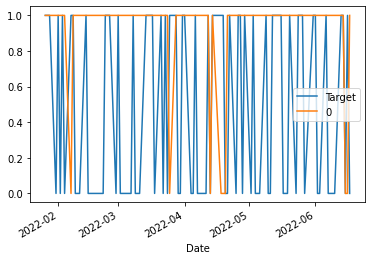

In [21]:
combined.plot()


## Backtesting

The precision score is less than 50% which is not what we expected, so we need to improve our model. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past).

Our backtesting method will loop over the dataset, and train a model every 250 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

* Split the training and test data
* Train a model
* Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.



In [22]:
# creating a prediciton function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [23]:
# createing a backtest function
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [24]:
# prediciting the target using the bcaktest function
predictions = backtest(msft_90s, model, predictors)

In [25]:
# Check the number of days the algorithm predicted the price will go up
predictions["Predictions"].value_counts()

0    3723
1    1957
Name: Predictions, dtype: int64

In [26]:
# calculating the precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.5063873275421563


## Improving accuracy

The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.


In [27]:
# we will calculate rolling averages for 2 days, a week, 3 months then 1 year.
horizons = [2,5,60,250]

#Assign the new columns created to the list new_predictors
new_predictors=[]

for horizon in horizons:
    rolling_averages = msft_90s.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    msft_90s[ratio_column] = msft_90s["Close"]/ rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    msft_90s[trend_column] = msft_90s.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


In [28]:
# check the new columns added
msft_90s

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,
1990-01-02,0.380843,0.387390,0.375932,0.387390,53035200,0.389573,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.390664,0.393938,0.386299,0.389573,113774400,0.401031,1,1.002809,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,0.389573,0.401577,0.387390,0.401031,125740800,0.391210,0,1.014493,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,0.399394,0.401577,0.390664,0.391210,69566400,0.397212,1,0.987603,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.390665,0.397212,0.386299,0.397212,58982400,0.396120,0,1.007612,1.0,1.009988,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-13,245.110001,249.020004,241.529999,242.259995,46135800,244.490005,1,0.978334,0.0,0.929660,1.0,0.865350,28.0,0.817370,126.0
2022-06-14,243.860001,245.740005,241.509995,244.490005,28651500,251.759995,1,1.004581,1.0,0.958829,1.0,0.876197,28.0,0.825053,126.0
2022-06-15,248.309998,255.300003,246.419998,251.759995,33111700,244.970001,0,1.014650,2.0,1.001998,2.0,0.904775,29.0,0.849650,127.0


In [29]:
# dropping all the null values
msft_90s = msft_90s.dropna()

In [30]:
msft_90s

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,
1990-12-27,0.654745,0.656927,0.650380,0.652562,22629600,0.654745,1,0.998330,0.0,0.993355,2.0,1.103796,31.0,1.201478,132.0
1990-12-28,0.650380,0.656927,0.648197,0.654745,20268000,0.656927,1,1.001670,1.0,0.998004,2.0,1.104973,32.0,1.203148,132.0
1990-12-31,0.654745,0.656927,0.650380,0.656927,23702400,0.652562,0,1.001664,2.0,1.002665,2.0,1.105636,33.0,1.204892,132.0
1991-01-02,0.654745,0.656927,0.652562,0.652562,38109600,0.656927,1,0.996666,1.0,0.997331,2.0,1.095606,32.0,1.194595,132.0
1991-01-03,0.652562,0.663475,0.652562,0.656927,52826400,0.662383,1,1.003334,1.0,1.003334,3.0,1.100448,32.0,1.200303,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-10,260.579987,260.579987,252.529999,252.990005,31422800,242.259995,0,0.977210,0.0,0.951491,1.0,0.900874,29.0,0.853422,126.0
2022-06-13,245.110001,249.020004,241.529999,242.259995,46135800,244.490005,1,0.978334,0.0,0.929660,1.0,0.865350,28.0,0.817370,126.0
2022-06-14,243.860001,245.740005,241.509995,244.490005,28651500,251.759995,1,1.004581,1.0,0.958829,1.0,0.876197,28.0,0.825053,126.0


In [31]:
# Initialising the model with new parameters
model = RandomForestClassifier(n_estimators = 250, min_samples_split = 150, random_state=1)

In [32]:
# modifying the predict function to calculate probability
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>.60] = 1
    preds[preds<=.60] = 0
    preds = pd.Series(preds, index = test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [33]:
predictions = backtest(msft_90s, model, new_predictors)

In [34]:
predictions["Predictions"].value_counts()

0.0    5303
1.0     126
Name: Predictions, dtype: int64

In [36]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6031746031746031

<AxesSubplot:xlabel='Date'>

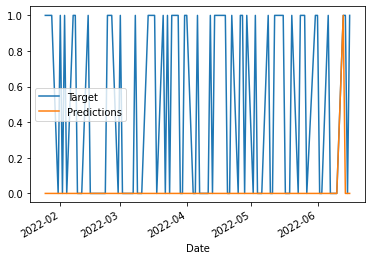

In [40]:
predictions[-100:].plot()

We have created our base model that can predict if the prices will go up with 60% confidence. We can further improve our model by tweaking the parameters or trying new models to predict.